In [1]:
from pathlib import Path

thispath = Path('__file__').resolve()
base_path = thispath.parent.parent
import sys; sys.path.insert(0, str(base_path))
from dataset.copd_dataset import DirLabCOPD

In [2]:

NORMALIZATION_CFG = {
    'norm_type': 'min-max',
    'mask': None,
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}

data = DirLabCOPD(
    data_path=base_path/'data',
    cases=['all'],
    partitions=['train'],
    return_lm_mask=True,
    normalization_cfg=None,
    return_body_masks=True,
    return_lung_masks=True
)

In [3]:
from utils.metrics import target_registration_error
import elastix.elastix_utils as e_utils
from utils.utils import save_img_from_array_using_metadata, get_landmarks_array_from_txt_file
import SimpleITK as sitk
import pandas as pd
from tqdm import tqdm
import time
import numpy as np

def run_experiment(dataset, param_maps_to_use, output_path, params_path, mask=None):
    results = {}
    for i in tqdm(range(len(dataset))):
        sample = data[i]
        # for pm in param_maps_to_use:
        # Define output paths
        pm = param_maps_to_use[-1]
        output_pm_path = output_path / pm.rstrip('.txt')
        output_pm_path.mkdir(exist_ok=True, parents=True)

        # Read and modify parameters file
        parameters_filename = params_path / pm
        result_path = output_pm_path / sample['case']
        result_path.mkdir(exist_ok=True, parents=True)
        
        # field_value_pairs = [('WriteResultImage', 'true'), ('ResultImageFormat', 'nii.gz')]
        field_value_pairs = [
            ('WriteResultImage', 'true'),
            ('ResultImageFormat', 'nii.gz')
        ]
        e_utils.modify_field_parameter_map(field_value_pairs, parameters_filename)

        # Create temporary image files with the preprocessings included and 
        # also for the selected binary masks.
        res_path = result_path / 'res_tmp'
        res_path.mkdir(exist_ok=True, parents=True)

        param_maps_to_use_ = [str(params_path / p) for p in param_maps_to_use] 
        # Inhale
        i_temp_path = res_path / 'i_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['i_img'], [0,1,2], [2,1,0]), sample['ref_metadata'], i_temp_path)
        i_body_mask_temp_path = res_path / 'i_body_mask_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['i_body_mask'], [0,1,2], [2,1,0]), sample['ref_metadata'], i_body_mask_temp_path)
        i_lungs_mask_temp_path = res_path / 'i_lungs_mask_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['i_lung_mask'], [0,1,2], [2,1,0]), sample['ref_metadata'], i_lungs_mask_temp_path)

        # Exhales
        e_temp_path = res_path / 'e_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['e_img'], [0,1,2], [2,1,0]), sample['ref_metadata'], e_temp_path)
        e_body_mask_temp_path = res_path / 'e_body_mask_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['e_body_mask'], [0,1,2], [2,1,0]), sample['ref_metadata'], e_body_mask_temp_path)
        e_lungs_mask_temp_path = res_path / 'e_lungs_mask_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['e_lung_mask'], [0,1,2], [2,1,0]), sample['ref_metadata'], e_lungs_mask_temp_path)

        # Register
        print(f"Estimating transformation case {sample['case']}...")
        start = time.time()
        if mask is None:
            transform_map_path = e_utils.elastix_wrapper(
                i_temp_path, e_temp_path, res_path.parent, param_maps_to_use_,
                verbose=False, keep_just_useful_files=False
            )
        elif mask == 'body':
            transform_map_path = e_utils.elastix_wrapper(
                i_temp_path, e_temp_path, res_path.parent, param_maps_to_use_,
                i_body_mask_temp_path, e_body_mask_temp_path, verbose=False,
                keep_just_useful_files=False
            )
        else:
            transform_map_path = e_utils.elastix_wrapper(
                i_temp_path, e_temp_path, res_path.parent, param_maps_to_use_,
                i_lungs_mask_temp_path, e_lungs_mask_temp_path, verbose=False,
                keep_just_useful_files=False
            )
        reg_time = time.time()-start
        case_path = Path(sample['i_img_path']).parent
        
        name = f"{sample['case']}_300_iBH_xyz_r1.txt"
        lm_points_filepath = case_path / name

        # Correct transformation parameters file
        field_value_pairs = [
            ('ResultImageFormat', 'nii.gz'),
            ('ResultImagePixelType', "float"),
            # ('FinalBSplineInterpolationorder', '0')
        ]
        e_utils.modify_field_parameter_map(field_value_pairs, transform_map_path)

        # Transform image
        print('Transforming points...')
        lm_out_filepath = res_path.parent / f'r_{name}'
        e_utils.transformix_wrapper(
            lm_points_filepath, lm_out_filepath, transform_map_path,
            points=True, verbose=False, keep_just_useful_files=False)
        
        
        # Get transformed landmarks positions
        landmarks = pd.read_csv(lm_out_filepath, header=None, sep='\t |\t', engine='python')
        landmarks.columns = ['point', 'idx', 'input_index', 'input_point', 'ouput_index', 'ouput_point', 'def']
        landmarks_input = [lm[-4:-1] for lm in np.asarray(landmarks.input_index.str.split(' '))]
        landmarks_input = np.asarray(landmarks_input).astype('int')

        landmarks = get_landmarks_array_from_txt_file(lm_out_filepath)
        
        # Get the TRE
        tre = target_registration_error(landmarks, sample['e_landmark_pts'], sample['ref_metadata']['spacing'])
        print(f'TRE estimated: {tre[0]}, {tre[1]}')
        print(f'Initial displacement GT: {sample["disp_mean"]}, {sample["disp_mean"]}')
        results[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }
    return results
    

In [4]:
import json

base_path = Path().resolve().parent

results_path = base_path / 'experiments/elastix/results.json'
# results = {}

# with open(results_path, 'w') as json_file:
#     json.dump(results, json_file, indent=4, separators=(',', ': '))

In [20]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    # 'Parameters.MI.Fine.Bspline_tuned.txt',
    # 'Parameters.MI.RP.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse-None-None'
results[experiment_name] = \
    run_experiment(data, param_maps_to_use, output_path, params_path, None)

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:03<03:10, 63.39s/it]

TRE estimated: 8.8, 4.81
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [01:57<01:56, 58.12s/it]

TRE estimated: 13.15, 6.29
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [03:00<01:00, 60.10s/it]

TRE estimated: 4.91, 2.97
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [04:02<00:00, 60.62s/it]

TRE estimated: 9.86, 4.04
Initial displacement GT: 30.9, 30.9


In [21]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    'Parameters.MI.Fine.Bspline_tuned.txt',
    # 'Parameters.MI.RP.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse+Fine-None-None'

try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:55<05:46, 115.50s/it]

TRE estimated: 8.79, 4.82
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [03:37<03:35, 107.75s/it]

TRE estimated: 13.15, 6.28
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [05:33<01:51, 111.53s/it]

TRE estimated: 4.89, 2.98
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [07:31<00:00, 112.81s/it]

TRE estimated: 9.84, 4.06
Initial displacement GT: 30.9, 30.9


In [5]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    'Parameters.MI.Fine.Bspline_tuned.txt',
    'Parameters.MI.RP.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse+Fine+RP-None-None'

try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None)
except:
    results[experiment_name] = None


with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [03:36<10:49, 216.66s/it]

TRE estimated: 7.49, 5.16
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [06:55<06:51, 205.91s/it]

TRE estimated: 14.15, 7.2
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [10:35<03:32, 212.64s/it]

TRE estimated: 4.84, 3.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [14:19<00:00, 214.89s/it]

TRE estimated: 8.61, 3.72
Initial displacement GT: 30.9, 30.9


In [6]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    'Parameters.MI.Fine.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse+Fine-Body-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'body')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:51<05:34, 111.41s/it]

TRE estimated: 7.57, 5.42
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [03:30<03:28, 104.39s/it]

TRE estimated: 11.86, 6.22
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [05:24<01:48, 108.56s/it]

TRE estimated: 4.53, 2.83
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [07:21<00:00, 110.35s/it]

TRE estimated: 7.48, 3.78
Initial displacement GT: 30.9, 30.9


In [7]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    'Parameters.MI.Fine.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse+Fine-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:56<05:50, 116.77s/it]

TRE estimated: 4.12, 3.45
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [03:37<03:35, 107.51s/it]

TRE estimated: 6.61, 6.27
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [05:38<01:53, 113.37s/it]

TRE estimated: 1.79, 1.42
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [07:33<00:00, 113.39s/it]

TRE estimated: 4.73, 3.15
Initial displacement GT: 30.9, 30.9


In [8]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = ['anwai.txt']
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/anwai'
experiment_name = 'Anwai-bsplines-None-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [04:11<12:33, 251.32s/it]

TRE estimated: 5.49, 5.14
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [08:07<08:04, 242.18s/it]

TRE estimated: 9.7, 6.48
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [12:40<04:16, 256.42s/it]

TRE estimated: 3.36, 3.32
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [17:13<00:00, 258.30s/it]

TRE estimated: 7.17, 4.97
Initial displacement GT: 30.9, 30.9


In [9]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = ['anwai.txt']
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/anwai'
experiment_name = 'Anwai-bsplines-Body-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'body')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [04:27<13:22, 267.42s/it]

TRE estimated: 3.24, 3.59
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [08:40<08:38, 259.18s/it]

TRE estimated: 7.89, 6.79
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [13:07<04:22, 262.52s/it]

TRE estimated: 2.76, 2.95
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [17:37<00:00, 264.34s/it]

TRE estimated: 6.79, 6.41
Initial displacement GT: 30.9, 30.9


In [10]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = ['anwai.txt']
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/anwai'
experiment_name = 'Anwai-bsplines-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [04:37<13:52, 277.63s/it]

TRE estimated: 1.11, 1.05
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [09:13<09:13, 276.76s/it]

TRE estimated: 2.12, 2.62
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [14:16<04:48, 288.83s/it]

TRE estimated: 1.11, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [19:02<00:00, 285.54s/it]

TRE estimated: 1.39, 1.11
Initial displacement GT: 30.9, 30.9


In [11]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine-None-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


  0%|          | 0/4 [00:18<?, ?it/s]


In [12]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine-Body-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'body')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [00:33<01:40, 33.59s/it]

Transforming points...
TRE estimated: 12.3, 4.89
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [01:02<01:01, 30.69s/it]

Transforming points...
TRE estimated: 16.88, 5.74
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [01:36<00:32, 32.45s/it]

Transforming points...
TRE estimated: 5.38, 3.28
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [02:11<00:00, 32.80s/it]

Transforming points...
TRE estimated: 9.41, 3.73
Initial displacement GT: 30.9, 30.9


In [13]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [00:37<01:51, 37.27s/it]

Transforming points...
TRE estimated: 9.23, 5.16
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [01:06<01:04, 32.28s/it]

Transforming points...
TRE estimated: 10.82, 5.89
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [01:42<00:34, 34.22s/it]

Transforming points...
TRE estimated: 3.46, 1.72
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


 75%|███████▌  | 3/4 [02:05<00:41, 41.76s/it]


In [14]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
    'Parameters.Par0008.elastic.txt'
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine+elastic-None-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


  0%|          | 0/4 [00:18<?, ?it/s]


In [15]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
    'Parameters.Par0008.elastic.txt'
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine+elastic-Body-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'body')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:14<03:42, 74.18s/it]

TRE estimated: 9.85, 5.11
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [02:20<02:19, 69.56s/it]

TRE estimated: 13.01, 7.01
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [03:37<01:13, 73.08s/it]

TRE estimated: 3.6, 2.92
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [04:56<00:00, 74.11s/it]

TRE estimated: 6.99, 3.62
Initial displacement GT: 30.9, 30.9


In [16]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
    'Parameters.Par0008.elastic.txt'
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine+elastic-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:22<04:07, 82.62s/it]

TRE estimated: 2.88, 3.06
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [02:28<02:25, 72.65s/it]

TRE estimated: 6.88, 6.45
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [03:49<01:16, 76.66s/it]

TRE estimated: 1.35, 1.17
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


 75%|███████▌  | 3/4 [04:12<01:24, 84.09s/it]


In [17]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [00:52<02:36, 52.08s/it]

Transforming points...
TRE estimated: 10.06, 5.64
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [01:34<01:32, 46.27s/it]

Transforming points...
TRE estimated: 10.81, 5.92
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [02:26<00:49, 49.17s/it]

Transforming points...
TRE estimated: 3.55, 1.73
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [03:18<00:00, 49.55s/it]

Transforming points...
TRE estimated: 7.48, 5.12
Initial displacement GT: 30.9, 30.9


In [18]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R1-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R1-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:24<04:14, 84.69s/it]

Transforming points...
TRE estimated: 9.48, 6.01
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [02:34<02:32, 76.12s/it]

Transforming points...
TRE estimated: 9.54, 6.64
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [04:01<01:21, 81.01s/it]

Transforming points...
TRE estimated: 1.53, 1.51
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [05:26<00:00, 81.55s/it]

Transforming points...
TRE estimated: 6.22, 5.58
Initial displacement GT: 30.9, 30.9


In [19]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R2-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R2-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:35<04:47, 95.97s/it]

Transforming points...
TRE estimated: 8.45, 6.54
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [02:55<02:52, 86.23s/it]

Transforming points...
TRE estimated: 8.31, 6.96
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [04:33<01:31, 91.46s/it]

Transforming points...
TRE estimated: 1.27, 1.09
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [06:07<00:00, 91.93s/it]

Transforming points...
TRE estimated: 5.2, 5.38
Initial displacement GT: 30.9, 30.9


In [20]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R4-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R4-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:56<05:50, 116.97s/it]

Transforming points...
TRE estimated: 6.06, 6.84
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [03:35<03:32, 106.22s/it]

Transforming points...
TRE estimated: 7.3, 6.83
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [05:36<01:52, 112.68s/it]

Transforming points...
TRE estimated: 1.36, 1.25
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [07:31<00:00, 112.86s/it]

Transforming points...
TRE estimated: 4.69, 5.01
Initial displacement GT: 30.9, 30.9


In [21]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R6-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R6-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [02:18<06:55, 138.63s/it]

Transforming points...
TRE estimated: 7.94, 6.99
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [04:14<04:11, 125.53s/it]

Transforming points...
TRE estimated: 10.91, 8.79
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [06:35<02:12, 132.20s/it]

Transforming points...
TRE estimated: 1.56, 1.67
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [08:49<00:00, 132.46s/it]

Transforming points...
TRE estimated: 9.52, 6.33
Initial displacement GT: 30.9, 30.9


In [22]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R8-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R8-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [02:45<08:15, 165.21s/it]

Transforming points...
TRE estimated: 7.75, 6.37
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [04:59<04:53, 146.77s/it]

Transforming points...
TRE estimated: 11.16, 8.68
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [07:46<02:36, 156.20s/it]

Transforming points...
TRE estimated: 1.77, 1.9
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [10:19<00:00, 154.89s/it]

Transforming points...
TRE estimated: 10.76, 6.31
Initial displacement GT: 30.9, 30.9


In [23]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R8-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R8ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [02:20<07:02, 140.75s/it]

Transforming points...
TRE estimated: 1.22, 1.11
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 25%|██▌       | 1/4 [03:15<09:45, 195.25s/it]


In [24]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R6-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R6ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [02:05<06:15, 125.03s/it]

Transforming points...
TRE estimated: 1.2, 1.18
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [03:48<03:45, 112.58s/it]

Transforming points...
TRE estimated: 3.55, 4.54
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [05:55<01:58, 118.85s/it]

Transforming points...
TRE estimated: 1.21, 0.99
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [07:58<00:00, 119.53s/it]

Transforming points...
TRE estimated: 1.64, 1.32
Initial displacement GT: 30.9, 30.9


In [25]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R4-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R4ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:49<05:29, 109.87s/it]

Transforming points...
TRE estimated: 1.21, 1.07
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [03:23<03:20, 100.20s/it]

Transforming points...
TRE estimated: 3.29, 4.16
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
TRE estimated: 1.17, 0.99
Initial displacement GT: 12.29, 12.29


 75%|███████▌  | 3/4 [05:14<01:45, 105.02s/it]

Estimating transformation case copd4...


100%|██████████| 4/4 [07:01<00:00, 105.38s/it]

Transforming points...
TRE estimated: 1.69, 1.56
Initial displacement GT: 30.9, 30.9


In [26]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R2-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R2ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:32<04:38, 92.78s/it]

Transforming points...
TRE estimated: 4.65, 6.16
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [02:50<02:48, 84.09s/it]

Transforming points...
TRE estimated: 5.33, 6.44
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [04:24<01:28, 88.71s/it]

TRE estimated: 1.22, 1.01
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [05:57<00:00, 89.43s/it]

Transforming points...
TRE estimated: 2.72, 3.57
Initial displacement GT: 30.9, 30.9


In [28]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df = []
for exp_name in results.keys():
    if results[exp_name] is None:
        row = [None, None, None, None, None]
    else:
        for case in results[exp_name].keys():
            columns = ['exp_name'] + list(results[exp_name][case].keys()) + ['case']
            row = [exp_name] + list(results[exp_name][case].values()) + [case]
            df.append(row)
df = pd.DataFrame(df, columns=columns)
df
    

,exp_name,mean_tre,std_tre,time,case
0,P0007-Coarse-None-None,8.80,4.81,42.555441,copd1
1,P0007-Coarse-None-None,13.15,6.29,38.796581,copd2
2,P0007-Coarse-None-None,4.91,2.97,43.044862,copd3
3,P0007-Coarse-None-None,9.86,4.04,42.692156,copd4
4,P0007-Coarse+Fine-None-None,8.79,4.82,93.952092,copd1
...,...,...,...,...,...
71,P0003-affine+R4ug-Lungs-None,1.69,1.56,91.178928,copd4
72,P0003-affine+R2ug-Lungs-None,4.65,6.16,76.972659,copd1
73,P0003-affine+R2ug-Lungs-None,5.33,6.44,65.153622,copd2
74,P0003-affine+R2ug-Lungs-None,1.22,1.01,77.789020,copd3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


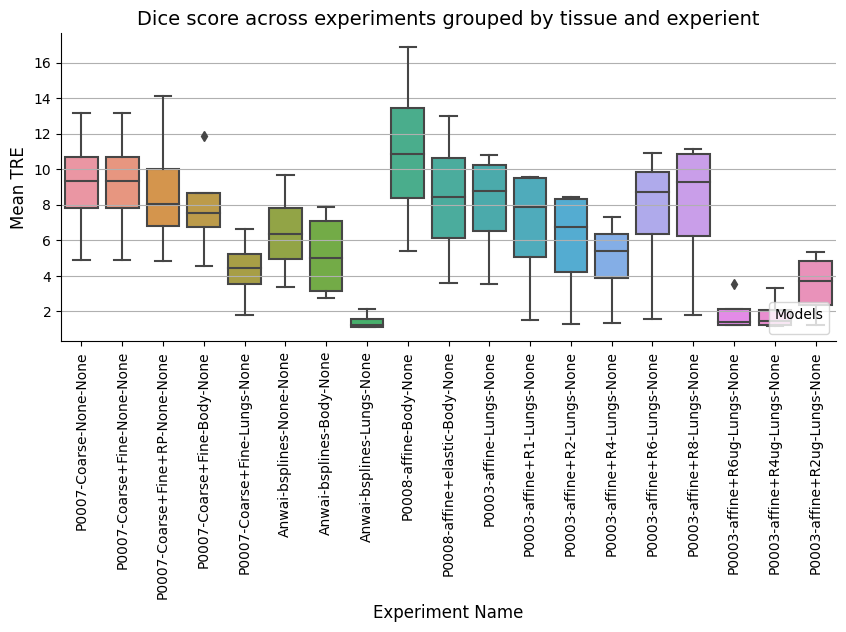

In [40]:
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.boxplot(data=df, x="exp_name", y="mean_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


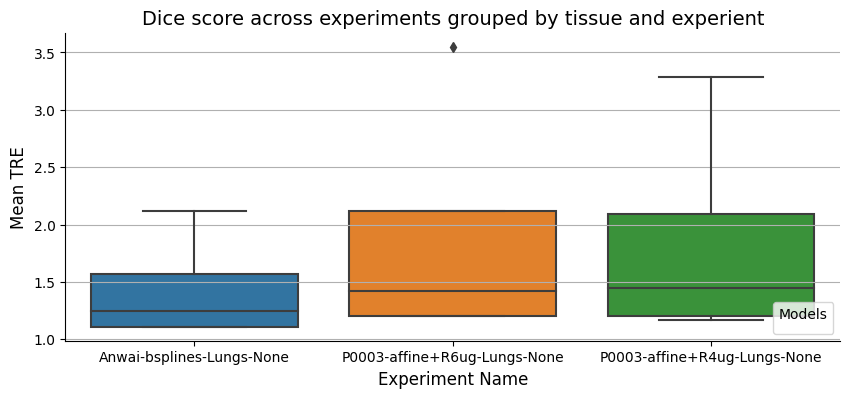

In [43]:
df_temp = df.loc[df.exp_name.isin(['Anwai-bsplines-Lungs-None', 'P0003-affine+R6ug-Lungs-None', 'P0003-affine+R4ug-Lungs-None'])]
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.boxplot(data=df_temp, x="exp_name", y="mean_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
# plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

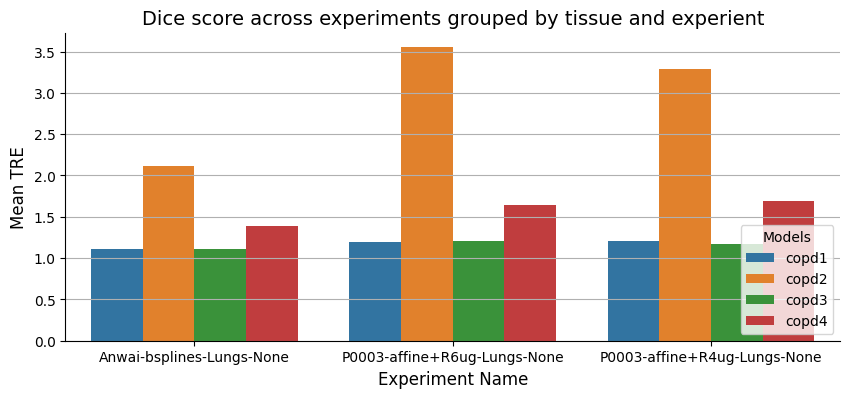

In [50]:
df_temp = df.loc[df.exp_name.isin(['Anwai-bsplines-Lungs-None', 'P0003-affine+R6ug-Lungs-None', 'P0003-affine+R4ug-Lungs-None'])]
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.barplot(data=df_temp, x="exp_name", y="mean_tre", hue='case')
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
# plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

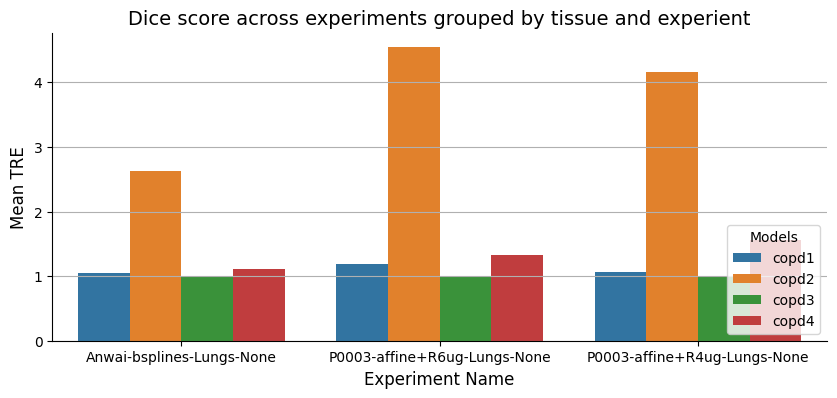

In [51]:
df_temp = df.loc[df.exp_name.isin(['Anwai-bsplines-Lungs-None', 'P0003-affine+R6ug-Lungs-None', 'P0003-affine+R4ug-Lungs-None'])]
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.barplot(data=df_temp, x="exp_name", y="std_tre", hue='case')
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
# plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)